In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data = pd.read_csv('/root/code/oscarthse/portfolio_manager/raw_data/AAPL_technical_analysis.csv')
aapl = pd.read_csv('/root/code/oscarthse/portfolio_manager/raw_data/AAPL.csv')

# Geometric Brownian Motion

In [4]:
aapl['4. close'][40000]

10.424

In [5]:
aapl['4. close'][40120]

10.527

In [6]:
type(aapl['4. close'])

pandas.core.series.Series

In [7]:
log_returns = np.log(aapl['4. close'] / aapl['4. close'].shift(1))
log_returns[100000]

0.007558971215233926

In [8]:
last_data_point = 40000

mu = log_returns[35000:40000].mean()
sigma = log_returns[35000:40000].std()
n = 1000
T = 100
M= 1000
S0 = aapl['4. close'][last_data_point]

In [9]:
# calc each time step
dt = T/n

# simulation using numpy arrays
St = np.exp(
    (mu - sigma ** 2 / 2) * dt
    + sigma * np.random.normal(0, np.sqrt(dt), size=(M,n)).T
)

# include array of 1's
St = np.vstack([np.ones(M), St])

# multiply through by S0 and return the cumulative product of elements along a given simulation path (axis=0).
St = S0 * St.cumprod(axis=0)

# Define time interval correctly
time = np.linspace(0,T,n+1)

# Require numpy array that is the same shape as St
tt = np.full(shape=(M,n+1), fill_value=time).T

In [10]:
def gbm(close_prices, last_data_point, window_size=5000, n = 1000, T = 100, M = 1000):

    '''
    Runs M (default 1000) GBM simulations starting at the last_data_point
    index of the input data

    Args:
        close_prices (pd.Series): Pandas series containing the close prices of the desired stock
        last_data_point (int): Index of the data point to start simulations from
        window_size (int): Size of the window of time to calculate drift and volatility
        n (int): Number of random steps to simulate
        T (int): Time in 30-minute intervals
        M (int) = Number of paths to simulate

    Returns:
        np.array: A 2D array containing the trajectories of all simulated paths
    '''

    # Calculate log returns
    log_returns = np.log(close_prices / close_prices.shift(1))
    # Drift coefficient
    mu = log_returns[last_data_point - window_size : last_data_point].mean()
    # Volatility
    sigma = log_returns[last_data_point - window_size : last_data_point].std()
    # Initial stock price
    S0 = close_prices[last_data_point]
    # Calculate each time step
    dt = T/n

    # Simulation using numpy arrays
    St = np.exp(
        (mu - sigma ** 2 / 2) * dt
        + sigma * np.random.normal(0, np.sqrt(dt), size=(M,n)).T
    )
    # Include array of 1's
    St = np.vstack([np.ones(M), St])
    # Mulltiply through by S0 and return the cumulative product
    # of elements along a given simulation path (axis=0).
    St = S0 * St.cumprod(axis=0)

    return St

In [32]:
test = gbm(aapl['4. close'], 40000,window_size=5000, n=10000, T = 100, M = 1000 )
var(95, test)

4.610143031161995

In [24]:
print(test[-1].mean())

10.479529234924883


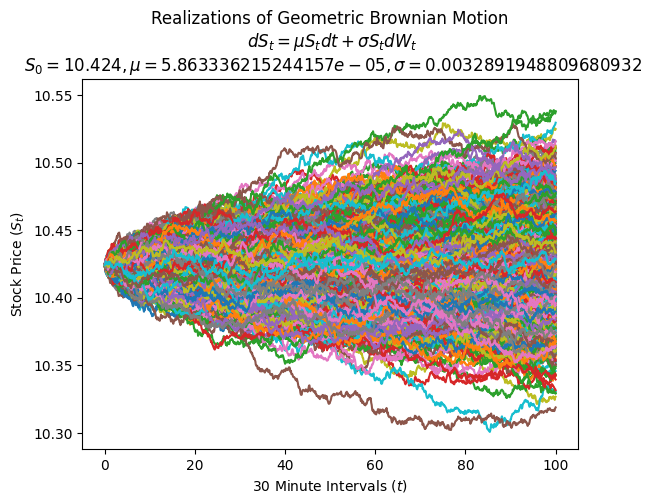

In [17]:
plt.plot(tt, test)
plt.xlabel("30 Minute Intervals $(t)$")
plt.ylabel("Stock Price $(S_t)$")
plt.title(
    "Realizations of Geometric Brownian Motion\n $dS_t = \mu S_t dt + \sigma S_t dW_t$\n $S_0 = {0}, \mu = {1}, \sigma = {2}$".format(S0, mu, sigma)
)
plt.show()

In [85]:
St[-1].mean()

np.float64(10.474187729405894)

In [86]:
(St[0].mean())

np.float64(10.424000000000001)

In [87]:
St[-1].std()

np.float64(0.35512601472066463)

# Risk Calculations


## Value at Risk (VaR)
VaR gives you the worst expected loss at the given confidence level. For example, a 95% VaR of -2% means that there is a 5% chance the asset will lose more than 2% over the time the simulations ran.

In [25]:
def var(confidence_interval: int, simulations):
    simulations.sort()
    var = np.percentile(simulations[-1], 100 - confidence_interval)
    loss = (1 - var / simulations[0][0])*100
    return loss

In [21]:
var(95, test)

0.5395849331919389

## Conditional Value at Risk (CVaR)
CVaR, also known as Expected Shortfall, measures the expected loss given that the loss is beyond the VaR threshold. It provides an average of the worst losses.

In [22]:
def cvar(simulations, confidence_interval):
    simulations.sort()
    var = np.percentile(simulations[-1], 100 - confidence_interval)
    cvar = simulations[simulations <= var].mean()
    loss = (1 - cvar/simulations[0][0]) * 100
    return loss


In [24]:
cvar(test, 95)

0.6647403513369121

## Volatility
Volatility measures the standard deviation of returns, reflecting the overall variability or risk of the asset's price.

In [109]:
def volatility(simulations):
    return simulations[-1].std()

In [113]:
volatility(St)

np.float64(0.3878723665533443)

## Maximum Drawdown
Maximum Drawdown measures the largest peak-to-trough decline in the price path over the time horizon. It represents the worst loss an investor could experience during the period.

In [131]:
def max_drawdown(simulations):
    return np.min(simulations[-1] / np.maximum.accumulate(simulations[-1]) - 1)


In [133]:
max_drawdown(St)

np.float64(-0.09570497304298287)

In [9]:
from gbm import gbm

In [11]:
gbm(aapl['4. close'], 40000).shape

(1001, 1000)